In [68]:
import numpy as np
import random as rnd
import scipy.spatial.distance as distance
import math
import scipy.stats as stats
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plot

In [69]:
#TODO create dict to map key to data correspondence to mu/sigma, 4 keys, mu, sigma, discover mu, discover sigma 
    #Use nested dictionaries?
#TODO scatterplot on the input data, color code different classes, plot means, sigmas, shape of data
D = 4; K = 0; Beta = 0.05; delta = 0.01
#chi2 = 7.78
vmin = 5; spmin = 3
mus = np.ndarray([D + 1,2]); sigmas = np.ndarray([D+1,2,2])
mus = np.array([[1, 1], [10, 10], [10,1], [1,10], [5,5]])
for i in range(D + 1):
    #mus[i] = [2 * i / 3 * D, 1 - 2 * i / 3 * D]
    #mus[i] = [2 * rnd.random() * D, 1 - 2 * rnd.random() * D]
    sigmas[i] = [[1, 0], [0, 1]]
    
    #sigmas[i] = [[(i % 3 + 2) / D, 0], [0, (1 % 3 + 2) / D]]
    #sigmas[i] = [[(rnd.random() * 3 / D), 0], [0, (rnd.random() * 3) / D]]

    
    
startingMus = mus
numvectors = 250; lenvectors = 2
X = np.ndarray((numvectors, lenvectors))
normalizedMus = np.ndarray([numvectors, 2])



for i in range(numvectors):
    index = i % (D + 1)
    
    summed = 0
    for j in range(lenvectors):
        X[i] = np.random.multivariate_normal(mus[index], sigmas[index])
        summed += X[i,j] ** 2

    #for j in range(lenvectors):
    #    X[i,j] = X[i,j] / math.sqrt(summed)
    
    #normalizedMus[i] = startingMus[index] / math.sqrt(summed)
    
    #print(X[i])
    #print(mus[index])
    #print(sigmas[index])
    #print()

#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)
#Xnew = scaler.inverse_transform(Z)


#print(scaler.mean_)
gm  = GaussianMixture(n_components = 5, random_state = 0).fit(X)
cluster = gm.predict_proba(X)
print(cluster)
#
#print(X)
#print(scaler.transform(X))


#TODO scatterplot on generated to make sure we have a bell shape
#TODO use linspace 
#TODO min max normalization
#TODO preprocessing library

[[1.30178754e-18 2.39277695e-08 1.56140965e-31 1.23787860e-17
  9.99999976e-01]
 [6.49496425e-19 1.63888648e-11 1.00000000e+00 5.07862070e-15
  2.35261978e-40]
 [1.00000000e+00 1.46020032e-11 1.91787676e-22 3.55973295e-44
  8.10654922e-22]
 ...
 [9.99990561e-01 9.43842197e-06 3.12962852e-21 1.24579856e-32
  9.75720623e-11]
 [2.42595544e-36 2.68508751e-10 1.24652600e-17 1.00000000e+00
  1.29785183e-25]
 [3.59234419e-10 9.99999039e-01 8.61397124e-12 3.35301233e-09
  9.57655456e-07]]


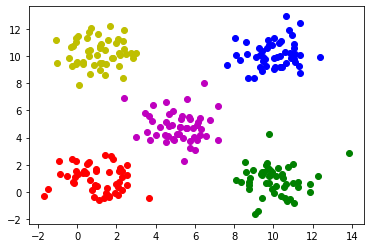

In [70]:
Xs = [[],[],[],[],[]]
Ys = [[],[],[],[],[]]
colors = ['r','b','g','y','m']


for i in range(len(X)):
    index = i % 5
    Xs[index].append(X[i,0])
    Ys[index].append(X[i,1])


plot.figure(num = 1)
for i in range(5):
    plot.scatter(Xs[i], Ys[i], c =colors[i])


In [71]:
sigma = np.std(X[:5]) #sigma should be representative of only a part of the data stream
sigmaInv = delta * sigma ** -1
#print(sigmaInv)
alpha = sigmaInv * np.identity(lenvectors)
covarDet = np.linalg.det(alpha) ** -1
#print(alpha)

alphas = {}
mus = {}
covDets = {}
comProbs = {}
ages = {}
accumulators ={}
correspondingData = {}

alphas[0] = alpha
covDets[0] = covarDet
mus[0] = X[0]
comProbs[0] = 1
ages[0] = 1
accumulators[0] = 1
K = 1
remainingK = D
correspondingData[0] = [0]
correspondingData[-1] = []

In [72]:
for i in range(len(X)):
    if i == 0:
        continue
    updated = False
    
    for j in range(K):
        if j >= K:
            break
        if (ages[j] > vmin) and (accumulators[j] < spmin):
            comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK)
            remainingK += 1
            K -= 1
            print('call remove')
            print()
            
    for j in range(K):
        if i == j:
            continue
        
        print('(' + str(i) + ', ' + str(j) + ')')

        dist = distance.mahalanobis(X[i], mus[j], alphas[j]) ** 2
        print(dist)
        #dist2 = stats.multivariate_normal.logpdf(X[i], mus[j], np.linalg.inv(alpha))
        #dist3 = math.exp(dist2)
        #print(dist2)
        #print(dist3)
        #dist2 = stats.multivariate_normal.pdf(X[i], mus[j], np.linalg.inv(alpha))
        #print(dist2)
        
        if dist < 0.1:
            print('call update')
            print()
            correspondingData[j].append(i)
            update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, sigmaInv, X[i])
            updated = True
            
    if not updated and not remainingK == 0:
        print('call create')
        print()
        correspondingData[K] = [i]
        K = create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, X[i])
        remainingK -= 1

(1, 0)
0.35880766695289357
call create

(2, 0)
0.31361241378267585
(2, 1)
0.2043431572696458
call create

(3, 0)
0.1478974039867983
(3, 1)
0.24125010587639026
(3, 2)
0.5405725355464657
call create

(4, 0)
0.06010240521938626
call update

5.380148028492126e-05
0.48
(4, 1)
0.13626305885853152
(4, 2)
0.13589159720373784
(4, 3)
0.14533097428689512
(5, 0)
0.02464538446649327
call update

0.0001197203276405637
0.39999288875697947
(5, 1)
0.40061333794747434
(5, 2)
0.2659851104638147
(5, 3)
0.23129649349075004
(6, 0)
0.4740685047875667
(6, 1)
0.003919575701967201
call update

5.533426827808268e-05
0.20488159713735526
(6, 2)
0.19537063777397504
(6, 3)
0.1896670365256715
(7, 0)
0.44610300996890806
(7, 1)
0.4484179848927063
(7, 2)
0.0030884336707928555
call update

5.5357268374903564e-05
0.14591992688611513
(7, 3)
0.5613823340581338
(8, 0)
0.25187907960921524
(8, 1)
0.4175959341388861
(8, 2)
0.5112854168032022
(8, 3)
0.007905822358645552
call update

5.522409009295053e-05
0.11167425585389225
(9, 

C:\Users\mwats\Anaconda3\lib\site-packages\scipy\spatial\distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


1.1865612026608041
(140, 1)
nan
(140, 2)
0.012748928165197612
call update

5.5229953941770285e-05
0.0003265175660380504
(140, 3)
0.47021321312649816
call remove

(141, 0)
195.9605683480106
(141, 1)
nan
(141, 2)
0.008304482209319664
call update

5.521308337621595e-05
0.0003253814389338074
(142, 0)
62.89801050176177
(142, 1)
nan
(142, 2)
0.386288491847739
call create

(143, 0)
64.5255293408736
(143, 1)
nan
(143, 2)
0.35647520170266545
(143, 3)
0.2783517479180421
call create

(144, 0)
47.160605561138276
(144, 1)
nan
(144, 2)
0.3916175627675427
(144, 3)
0.12149154243565057
(144, 4)
0.034947523795620626
call update

5.4482438592966176e-05
0.0002903471462502178
(145, 0)
0.1143247933952554
(145, 1)
nan
(145, 2)
1.2666387458500559
(145, 3)
0.17343501967278635
(145, 4)
0.254773725557712
(146, 0)
226.42657752421573
(146, 1)
nan
(146, 2)
0.003727059466096808
call update

5.537553897723412e-05
0.000325497704033487
(146, 3)
0.14838664884319935
(146, 4)
0.20538520746507677
(147, 0)
48.59907157744109

In [73]:
def create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, x):
    accumulators[K] = 1
    ages[K] = 1
    alphas[K] = sigmaInv * np.identity(len(alphas[0]))
    comProbs[K] = 1 / sum(accumulators.values())
    covDets[K] = np.linalg.det(alphas[K]) ** -1
    mus[K] = x
    K += 1
    return K


In [74]:
def remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK):
    correspondingData[-1].append(correspondingData[j])
    
    for i in range(j,len(ages) - 1):
        accumulators[i] = accumulators.pop(i + 1)
        ages[i] = ages.pop(i + 1)
        alphas[i] = alphas.pop(i + 1)
        comProbs[i] = comProbs.pop(i + 1)
        correspondingData[i] = correspondingData.pop(i + 1)
        covDets[i] = covDets.pop(i + 1)
        mus[i] = mus.pop(i + 1)
    
    comProbs = removeHelper(comProbs, accumulators)
    return comProbs

In [75]:
def removeHelper(comProbs, accumulators):
    val = len(accumulators)
    for i in range(val):
        summed = 0
        for j in range(val):
            summed += accumulators[j]
        comProbs[i] = accumulators[i] / summed
    return comProbs

In [76]:
def update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, sigmaInv, x):
    dist = distance.mahalanobis(x, mus[j], alphas[j]) ** 2
    pxj = 1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[j])) * math.exp(-0.5 * dist)
    
    print(pxj)
    
    pjx = pxj * comProbs[j]
    totProbs = 0
    for i in range(K):
        pxi =  1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[i])) * math.exp(-0.5 * dist)
        totProbs += pxi * comProbs[i]
    pjx /= totProbs
    
    print(pjx)
    
    ages[j] += 1
    accumulators[j] += pjx
    
    ej = x - mus[j]
    weight = pjx / accumulators[j]
    
    deltaMu = weight * ej
    mus[j] += deltaMu
    
    oldAlpha = alphas[j]
    ejStar = x - mus[j]
    newAlpha = oldAlpha / (1 - weight) - (weight / (1 - weight) ** 2) * np.matmul(np.matmul(oldAlpha, ejStar), np.matmul(ejStar.transpose(), oldAlpha)) \
            / (1 + (weight / (1 - weight)) * np.matmul(np.matmul(ejStar.transpose(), oldAlpha),ejStar))
    alphas[j] = newAlpha +  (np.matmul(np.matmul(newAlpha, mus[j]), np.matmul(mus[j].transpose(), newAlpha))) \
            / (1 - np.matmul(np.matmul(mus[j].transpose(), newAlpha), mus[j]))
    
    comProbs[j] = accumulators[j] / sum(accumulators.values())
    
    newCovDet = (1 - weight) ** D * covDets[j] * (1 + weight/(1 - weight) * np.matmul(ejStar.transpose(), np.matmul(oldAlpha, ejStar)))
    covDets[j] = newCovDet * (1 - np.matmul(deltaMu.transpose(), np.matmul(newAlpha, deltaMu)))
    
    

In [77]:
print(K)
for i in range(len(mus)):
    print("mus ={}, sigmas = {}".format(mus[i],np.linalg.inv(alphas[i])))
    print("startingmus = {}, startingSigmas ={}".format(startingMus[i],sigmas[i]))
    print("corresponding data = {}".format(correspondingData[i]))
    print()

    #TODO map data to corresponding components, limit components
print(correspondingData)

5
mus =[0.81759039 1.0126309 ], sigmas = [[ 13.89264562 -13.51902967]
 [-13.51902967  13.89264562]]
startingmus = [1 1], startingSigmas =[[1. 0.]
 [0. 1.]]
corresponding data = [0, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 75, 100, 155, 165]

mus =[10.08557907  9.16028543], sigmas = [[ 226.43700272 -230.02992259]
 [-230.02992259  226.43700272]]
startingmus = [10 10], startingSigmas =[[1. 0.]
 [0. 1.]]
corresponding data = [106, 109, 111, 121]

mus =[11.03611267 10.89150212], sigmas = [[ 210.03520465 -246.63930512]
 [-246.63930512  210.03520465]]
startingmus = [10  1], startingSigmas =[[1. 0.]
 [0. 1.]]
corresponding data = [186, 191, 196]

mus =[ 2.364475   11.91291271], sigmas = [[ 220.82888076 -235.73927558]
 [-235.73927558  220.82888076]]
startingmus = [ 1 10], startingSigmas =[[1. 0.]
 [0. 1.]]
corresponding data = [208, 213, 218, 223]

mus =[9.76730568 1.17719269], sigmas = [[ 315.25307919 -141.42634923]
 [-141.42634923  315.25307919]]
startingmus = [5 5], startingSigm

nan
3
[-0.69805227  9.61871518]

5
[ 1.36071941 -0.48235489]

13
[-1.10720656 11.1575176 ]

15
[-1.50527645  0.17827401]

17
[10.39086587 -0.29105615]

25
[-0.87085956  1.31919568]

35
[ 1.59528799 -0.38281896]

38
[-0.2217083  10.70712518]



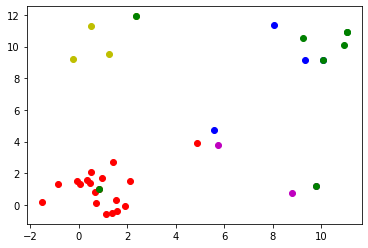

In [78]:
print(distance.mahalanobis(X[5], mus[1], alphas[1]) ** 2
)
#print(X[5])
#print(mus[1])
#print(alphas[1])
#print(distance.mahalanobis(X[4], mus[1], alphas[1]) ** 2)
#print(np.linalg.inv(alphas[1]))
newdist = np.matmul(X[5] - mus[1], np.matmul(alphas[1], X[5] - mus[1]))

for i in range(50):
    if X[i,0] < 0 or X[i,1] < 0:
        print(i)
        print(X[i])
        print()

colors = ['r', 'b', 'g', 'y', 'm']



for i in range(len(mus)):
    plot.figure(1)
    A = correspondingData[i]
    Xs_to_plot = X[A,0]
    Ys_to_plot = X[A,1]
    plot.scatter(Xs_to_plot, Ys_to_plot, c = colors[i])
    plot.scatter((mus[i][0]), (mus[i][1]), c = 'g')



In [79]:
print(accumulators)

{0: 16.667074939985653, 1: 1.0008883909136983, 2: 1.0004334303716338, 3: 1.0006664723078482, 4: 1.0004226552442728}


In [80]:
#np.linalg.eig(alphas[1])
print(np.linalg.eig(np.linalg.inv(alphas[1])))

(array([456.46692531,  -3.59291986]), array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]]))


In [81]:
def isposdef(X):
    return np.all(np.linalg.eigvals(X) > 0)

In [82]:

for i in range(K):
    print(isposdef(alphas[i]))
    print(isposdef(np.linalg.inv(alphas[i])))

True
True
False
False
False
False
False
False
True
True


In [83]:
Xs_to_plot

array([9.76730568, 5.73159393, 8.78087202])